<h1> Metrics for Blind Image Quality </h1>
Based on the following code: https://github.com/xinntao/BasicSR/tree/df5816f41c9bcc6d80286222e68e67e32974c2b1/basicsr/metrics

In [1]:
import cv2
import math
import numpy as np
from scipy.ndimage.filters import convolve
from scipy.special import gamma

In [2]:
def estimate_aggd_param(block):
    """Estimate AGGD (Asymmetric Generalized Gaussian Distribution) paramters.
    Args:
        block (ndarray): 2D Image block.
    Returns:
        tuple: alpha (float), beta_l (float) and beta_r (float) for the AGGD
            distribution (Estimating the parames in Equation 7 in the paper).
    """
    block = block.flatten()
    gam = np.arange(0.2, 10.001, 0.001)  # len = 9801
    gam_reciprocal = np.reciprocal(gam)
    r_gam = np.square(gamma(gam_reciprocal * 2)) / (
        gamma(gam_reciprocal) * gamma(gam_reciprocal * 3))

    left_std = np.sqrt(np.mean(block[block < 0]**2))
    right_std = np.sqrt(np.mean(block[block > 0]**2))
    gammahat = left_std / right_std
    rhat = (np.mean(np.abs(block)))**2 / np.mean(block**2)
    rhatnorm = (rhat * (gammahat**3 + 1) *
                (gammahat + 1)) / ((gammahat**2 + 1)**2)
    array_position = np.argmin((r_gam - rhatnorm)**2)

    alpha = gam[array_position]
    beta_l = left_std * np.sqrt(gamma(1 / alpha) / gamma(3 / alpha))
    beta_r = right_std * np.sqrt(gamma(1 / alpha) / gamma(3 / alpha))
    return (alpha, beta_l, beta_r)

<h2> NIQE: </h2>
A. Mittal, R. Soundararajan and A. C. Bovik, "Making a Completely Blind Image Quality Analyzer", submitted to IEEE Signal Processing Letters, 2012.

In [3]:
def compute_feature(block):
    """Compute features.
    Args:
        block (ndarray): 2D Image block.
    Returns:
        list: Features with length of 18.
    """
    feat = []
    alpha, beta_l, beta_r = estimate_aggd_param(block)
    feat.extend([alpha, (beta_l + beta_r) / 2])

    # distortions disturb the fairly regular structure of natural images.
    # This deviation can be captured by analyzing the sample distribution of
    # the products of pairs of adjacent coefficients computed along
    # horizontal, vertical and diagonal orientations.
    shifts = [[0, 1], [1, 0], [1, 1], [1, -1]]
    for i in range(len(shifts)):
        shifted_block = np.roll(block, shifts[i], axis=(0, 1))
        alpha, beta_l, beta_r = estimate_aggd_param(block * shifted_block)
        # Eq. 8
        mean = (beta_r - beta_l) * (gamma(2 / alpha) / gamma(1 / alpha))
        feat.extend([alpha, mean, beta_l, beta_r])
    return feat

In [4]:
def niqe(img,
         mu_pris_param,
         cov_pris_param,
         gaussian_window,
         block_size_h=96,
         block_size_w=96):
    """Calculate NIQE (Natural Image Quality Evaluator) metric.
    Ref: Making a "Completely Blind" Image Quality Analyzer.
    This implementation could produce almost the same results as the official
    MATLAB codes: http://live.ece.utexas.edu/research/quality/niqe_release.zip
    Note that we do not include block overlap height and width, since they are
    always 0 in the official implementation.
    For good performance, it is advisable by the official implemtation to
    divide the distorted image in to the same size patched as used for the
    construction of multivariate Gaussian model.
    Args:
        img (ndarray): Input image whose quality needs to be computed. The
            image must be a gray or Y (of YCbCr) image with shape (h, w).
            Range [0, 255] with float type.
        mu_pris_param (ndarray): Mean of a pre-defined multivariate Gaussian
            model calculated on the pristine dataset.
        cov_pris_param (ndarray): Covariance of a pre-defined multivariate
            Gaussian model calculated on the pristine dataset.
        gaussian_window (ndarray): A 7x7 Gaussian window used for smoothing the
            image.
        block_size_h (int): Height of the blocks in to which image is divided.
            Default: 96 (the official recommended value).
        block_size_w (int): Width of the blocks in to which image is divided.
            Default: 96 (the official recommended value).
    """
    assert img.ndim == 2, (
        'Input image must be a gray or Y (of YCbCr) image with shape (h, w).')
    # crop image
    h, w = img.shape
    num_block_h = math.floor(h / block_size_h)
    num_block_w = math.floor(w / block_size_w)
    img = img[0:num_block_h * block_size_h, 0:num_block_w * block_size_w]

    distparam = []  # dist param is actually the multiscale features
    for scale in (1, 2):  # perform on two scales (1, 2)
        mu = convolve(img, gaussian_window, mode='nearest')
        sigma = np.sqrt(
            np.abs(
                convolve(np.square(img), gaussian_window, mode='nearest') -
                np.square(mu)))
        # normalize, as in Eq. 1 in the paper
        img_nomalized = (img - mu) / (sigma + 1)

        feat = []
        for idx_w in range(num_block_w):
            for idx_h in range(num_block_h):
                # process ecah block
                block = img_nomalized[idx_h * block_size_h //
                                      scale:(idx_h + 1) * block_size_h //
                                      scale, idx_w * block_size_w //
                                      scale:(idx_w + 1) * block_size_w //
                                      scale]
                feat.append(compute_feature(block))

        distparam.append(np.array(feat))
        # TODO: matlab bicubic downsample with anti-aliasing
        # for simplicity, now we use opencv instead, which will result in
        # a slight difference.
        if scale == 1:
            h, w = img.shape
            img = cv2.resize(
                img / 255., (w // 2, h // 2), interpolation=cv2.INTER_LINEAR)
            img = img * 255.

    distparam = np.concatenate(distparam, axis=1)

    # fit a MVG (multivariate Gaussian) model to distorted patch features
    mu_distparam = np.nanmean(distparam, axis=0)
    # use nancov. ref: https://ww2.mathworks.cn/help/stats/nancov.html
    distparam_no_nan = distparam[~np.isnan(distparam).any(axis=1)]
    cov_distparam = np.cov(distparam_no_nan, rowvar=False)

    # compute niqe quality, Eq. 10 in the paper
    invcov_param = np.linalg.pinv((cov_pris_param + cov_distparam) / 2)
    quality = np.matmul(
        np.matmul((mu_pris_param - mu_distparam), invcov_param),
        np.transpose((mu_pris_param - mu_distparam)))
    quality = np.sqrt(quality)

    return quality

In [5]:
def calculate_niqe(img, crop_border, input_order='HWC', convert_to='gray'):
    """Calculate NIQE (Natural Image Quality Evaluator) metric.
    Ref: Making a "Completely Blind" Image Quality Analyzer.
    This implementation could produce almost the same results as the official
    MATLAB codes: http://live.ece.utexas.edu/research/quality/niqe_release.zip
    We use the official params estimated from the pristine dataset.
    We use the recommended block size (96, 96) without overlaps.
    Args:
        img (ndarray): Input image whose quality needs to be computed.
            The input image must be in range [0, 255] with float/int type.
            The input_order of image can be 'HW' or 'HWC' or 'CHW'. (BGR order)
            If the input order is 'HWC' or 'CHW', it will be converted to gray
            or Y (of YCbCr) image according to the ``convert_to`` argument.
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the metric calculation.
        input_order (str): Whether the input order is 'HW', 'HWC' or 'CHW'.
            Default: 'HWC'.
        convert_to (str): Whether coverted to 'y' (of MATLAB YCbCr) or 'gray'.
            Default: 'y'.
    Returns:
        float: NIQE result.
    """

    # we use the official params estimated from the pristine dataset.
    niqe_pris_params = np.load('./niqe_pris_params.npz')
    mu_pris_param = niqe_pris_params['mu_pris_param']
    cov_pris_param = niqe_pris_params['cov_pris_param']
    gaussian_window = niqe_pris_params['gaussian_window']

    img = img.astype(np.float32)
    '''if input_order != 'HW':
        if len(img.shape) == 2:
            img = img[..., None]
        if input_order == 'CHW':
            img = img.transpose(1, 2, 0)
        img = img.astype(np.float64)'''
        #if convert_to == 'y':
        #    img = to_y_channel(img)
        #elif convert_to == 'gray':
    img = cv2.cvtColor(img / 255., cv2.COLOR_BGR2GRAY) * 255.
    img = np.squeeze(img)

    if crop_border != 0:
        img = img[crop_border:-crop_border, crop_border:-crop_border]

    niqe_result = niqe(img, mu_pris_param, cov_pris_param, gaussian_window)

    return niqe_result

NIQE of Original Image: [[7.46841085]]


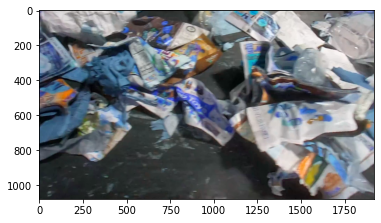

NIQE of OOF Deblurred Image: [[5.44624984]]


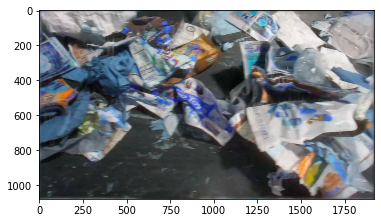

NIQE of Motion Deblurred Image: [[3.35853269]]


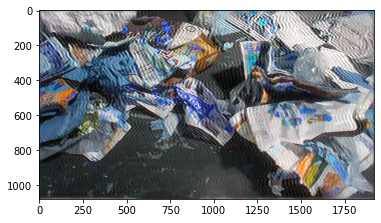

NIQE of GAN Deblurred Image: [[6.94427157]]


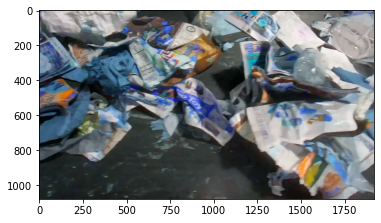

NIQE of GFN Deblurred Image: [[10.16281387]]


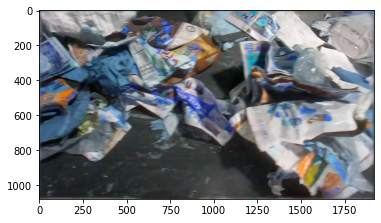

In [6]:
import matplotlib.pyplot as plt

# run niqe metrics on frame0 to test
og_path = '/projectnb/cs585/reardonc/frames/frame0.jpg'
gan_path = '/projectnb/cs585/goutermoutn/imagedeblur/gan_frames/g_frame0.jpg'
oof_path = '/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/oof_frame0.jpg'
motion_path = '/projectnb/cs585/reardonc/wiener_deconv_frames/w_frame0.jpg'
gfn_path = '/projectnb/cs585/reardonc/gfn_frames/frame0.jpg'

img1 = cv2.imread(og_path)
img2 = cv2.imread(oof_path)
img3 = cv2.imread(motion_path)
img4 = cv2.imread(gan_path)
img5 = cv2.imread(gfn_path)

niqe_result1 = calculate_niqe(img1, 0, input_order='HWC', convert_to='gray')
niqe_result2 = calculate_niqe(img2, 0, input_order='HWC', convert_to='gray')
niqe_result3 = calculate_niqe(img3, 0, input_order='HWC', convert_to='gray')
niqe_result4 = calculate_niqe(img4, 0, input_order='HWC', convert_to='gray')
niqe_result5 = calculate_niqe(img5, 0, input_order='HWC', convert_to='gray')

print("NIQE of Original Image: "+str(niqe_result1))
plt.imshow(img1)
plt.show()
print("NIQE of OOF Deblurred Image: "+str(niqe_result2))
plt.imshow(img2)
plt.show()
print("NIQE of Motion Deblurred Image: "+str(niqe_result3))
plt.imshow(img3)
plt.show()
print("NIQE of GAN Deblurred Image: "+str(niqe_result4))
plt.imshow(img4)
plt.show()
print("NIQE of GFN Deblurred Image: "+str(niqe_result5))
plt.imshow(img5)
plt.show()

Loading original frames...
Loading GAN frames...
Loading OOF frames...
Loading motion frames...
Loading GFN frames...
Average NIQE Score for Original Frames = [[6.14983075]]
Average NIQE Score for OOF Deblurred Frames = [[5.80980375]]
Average NIQE Score for Motion Deblurred Frames = [[3.38438792]]
Average NIQE Score for GAN Deblurred Frames = [[5.55656359]]
Average NIQE Score for GFN Deblurred Frames = [[9.67794649]]

Best NIQE Score for Original Frames = [[4.81333299]], frame #9960


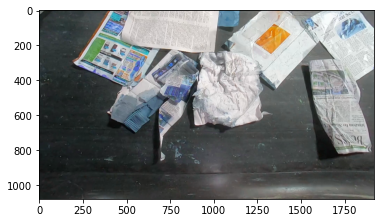

Best NIQE Score for OOF Deblurred Frames = [[5.12347856]], frame #10800


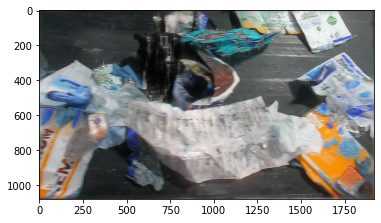

Best NIQE Score for Motion Deblurred Frames = [[2.60068594]], frame #10440


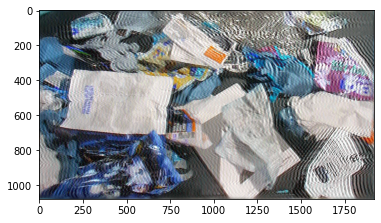

Best NIQE Score for GAN Deblurred Frames = [[4.63099979]], frame #2460


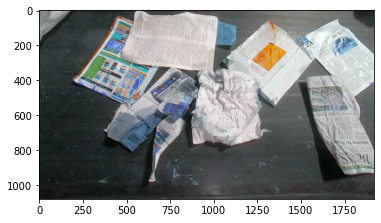

Best NIQE Score for GFN Deblurred Frames = [[8.6694466]], frame #1044


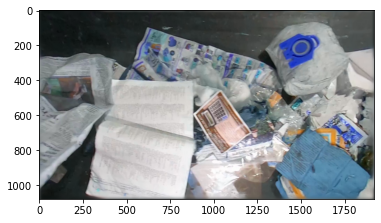

In [9]:
import sys
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# run on all frames and compute avg per method
og_path = '/projectnb/cs585/reardonc/frames/'
gan_path = '/projectnb/cs585/goutermoutn/imagedeblur/gan_frames/'
oof_path = '/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/'
motion_path = '/projectnb/cs585/reardonc/wiener_deconv_frames/'
gfn_path = '/projectnb/cs585/goutermoutn/imagedeblur/gfn-data/deblurred/'

np.set_printoptions(threshold=sys.maxsize)

print("Loading original frames...")
# first import original frames:
files = [join(og_path,f) for f in listdir(og_path) if isfile(join(og_path,f)) and join(og_path,f).endswith('.jpg')]
files.sort()
total_niqe_og = 0
count = 0
og_best_fr = None
og_best_fr_num = 0
og_best_score = 1000000
for i in range(len(files)):
    if i % 60 == 0:
        img = cv2.imread(files[i])
        result = calculate_niqe(img, 0, input_order='HWC', convert_to='gray')
        total_niqe_og += result
        count += 1
        if result < og_best_score:
            og_best_score = result
            og_best_fr = img
            og_best_fr_num = i
avg_niqe_og = total_niqe_og / (1.0*count)

print("Loading GAN frames...")
# then import gan frames:
files = [join(gan_path,f) for f in listdir(gan_path) if isfile(join(gan_path,f)) and join(gan_path,f).endswith('.jpg')]
files.sort()
total_niqe_gan = 0
count = 0
gan_best_fr = None
gan_best_fr_num = 0
gan_best_score = 1000000
for i in range(len(files)):
    if i % 60 == 0:
        img = cv2.imread(files[i])
        result = calculate_niqe(img, 0, input_order='HWC', convert_to='gray')
        total_niqe_gan += result
        count += 1
        if result < gan_best_score:
            gan_best_score = result
            gan_best_fr = img
            gan_best_fr_num = i
avg_niqe_gan = total_niqe_gan / (1.0*count)
    
print("Loading OOF frames...")
# then import oof frames:
files = [join(oof_path,f) for f in listdir(oof_path) if isfile(join(oof_path,f)) and join(oof_path,f).endswith('.jpg')]
files.sort()
total_niqe_oof = 0
count = 0
oof_best_fr = None
oof_best_fr_num = 0
oof_best_score = 1000000
for i in range(len(files)):
    if i % 60 == 0:
        img = cv2.imread(files[i])
        result = calculate_niqe(img, 0, input_order='HWC', convert_to='gray')
        total_niqe_oof += result
        count += 1
        if result < oof_best_score:
            oof_best_score = result
            oof_best_fr = img
            oof_best_fr_num = i
avg_niqe_oof = total_niqe_oof / (1.0*count)
    
print("Loading motion frames...")
# last import motion frames:
files = [join(motion_path,f) for f in listdir(motion_path) if isfile(join(motion_path,f)) and join(motion_path,f).endswith('.jpg')]
files.sort()
total_niqe_mot = 0
count = 0
mot_best_fr = None
mot_best_fr_num = 0
mot_best_score = 1000000
for i in range(len(files)):
    if i % 60 == 0:
        img = cv2.imread(files[i])
        result = calculate_niqe(img, 0, input_order='HWC', convert_to='gray')
        total_niqe_mot += result
        count += 1
        if result < mot_best_score:
            mot_best_score = result
            mot_best_fr = img
            mot_best_fr_num = i
avg_niqe_mot = total_niqe_mot / (1.0*count)

print("Loading GFN frames...")
files = [join(gfn_path,f) for f in listdir(gfn_path) if isfile(join(gfn_path,f)) and join(gfn_path,f).endswith('.jpg')]
files.sort()
total_niqe_gfn = 0
count = 0
gfn_best_fr = None
gfn_best_fr_num = 0
gfn_best_score = 1000000
for i in range(len(files)):
    img = cv2.imread(files[i])
    result = calculate_niqe(img, 0, input_order='HWC', convert_to='gray')
    total_niqe_gfn += result
    count += 1
    if result < gfn_best_score:
        gfn_best_score = result
        gfn_best_fr = img
        gfn_best_fr_num = i
avg_niqe_gfn = total_niqe_gfn / (1.0*count)

print("Average NIQE Score for Original Frames = "+str(avg_niqe_og))
print("Average NIQE Score for OOF Deblurred Frames = "+str(avg_niqe_oof))
print("Average NIQE Score for Motion Deblurred Frames = "+str(avg_niqe_mot))
print("Average NIQE Score for GAN Deblurred Frames = "+str(avg_niqe_gan))
print("Average NIQE Score for GFN Deblurred Frames = "+str(avg_niqe_gfn))
print("")
print("Best NIQE Score for Original Frames = "+str(og_best_score)+", frame #"+str(og_best_fr_num))
if og_best_fr is not None: 
    plt.imshow(og_best_fr)
    plt.show()
print("Best NIQE Score for OOF Deblurred Frames = "+str(oof_best_score)+", frame #"+str(oof_best_fr_num))
if oof_best_fr is not None: 
    plt.imshow(oof_best_fr)
    plt.show()
print("Best NIQE Score for Motion Deblurred Frames = "+str(mot_best_score)+", frame #"+str(mot_best_fr_num))
if mot_best_fr is not None: 
    plt.imshow(mot_best_fr)
    plt.show()
print("Best NIQE Score for GAN Deblurred Frames = "+str(gan_best_score)+", frame #"+str(gan_best_fr_num))
if gan_best_fr is not None: 
    plt.imshow(gan_best_fr)
    plt.show()
print("Best NIQE Score for GFN Deblurred Frames = "+str(gfn_best_score)+", frame #"+str(gfn_best_fr_num))
if gfn_best_fr is not None: 
    plt.imshow(gfn_best_fr)
    plt.show()

NIQE of Original Image: [[7.30658308]]


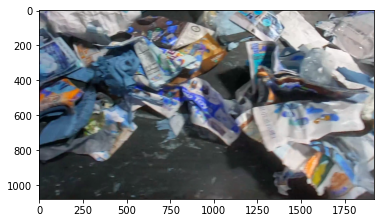

NIQE of OOF Deblurred Image: [[5.38883406]]


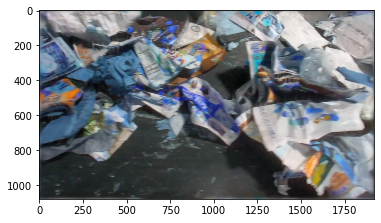

NIQE of Motion Deblurred Image: [[3.16105028]]


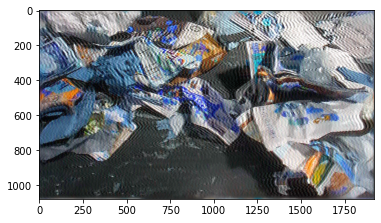

NIQE of GAN Deblurred Image: [[5.61734827]]


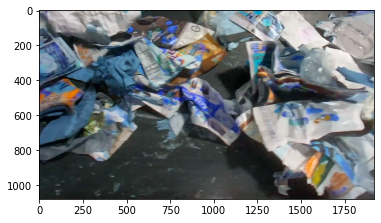

NIQE of GFN Deblurred Image: [[9.5757864]]


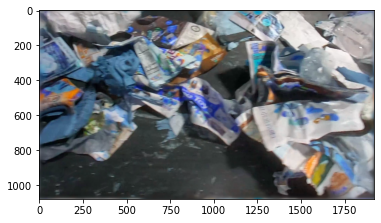

In [7]:
# compare frame 1 as well
og_path = '/projectnb/cs585/reardonc/frames/frame1.jpg'
gan_path = '/projectnb/cs585/goutermoutn/imagedeblur/gan_frames/g_frame1.jpg'
oof_path = '/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/oof_frame1.jpg'
motion_path = '/projectnb/cs585/reardonc/wiener_deconv_frames/w_frame1.jpg'
gfn_path = '/projectnb/cs585/reardonc/gfn_frames/frame1.jpg'

img1 = cv2.imread(og_path)
img2 = cv2.imread(oof_path)
img3 = cv2.imread(motion_path)
img4 = cv2.imread(gan_path)
img5 = cv2.imread(gfn_path)

niqe_result1 = calculate_niqe(img1, 0, input_order='HWC', convert_to='gray')
niqe_result2 = calculate_niqe(img2, 0, input_order='HWC', convert_to='gray')
niqe_result3 = calculate_niqe(img3, 0, input_order='HWC', convert_to='gray')
niqe_result4 = calculate_niqe(img4, 0, input_order='HWC', convert_to='gray')
niqe_result5 = calculate_niqe(img5, 0, input_order='HWC', convert_to='gray')

print("NIQE of Original Image: "+str(niqe_result1))
plt.imshow(img1)
plt.show()
print("NIQE of OOF Deblurred Image: "+str(niqe_result2))
plt.imshow(img2)
plt.show()
print("NIQE of Motion Deblurred Image: "+str(niqe_result3))
plt.imshow(img3)
plt.show()
print("NIQE of GAN Deblurred Image: "+str(niqe_result4))
plt.imshow(img4)
plt.show()
print("NIQE of GFN Deblurred Image: "+str(niqe_result5))
plt.imshow(img5)
plt.show()

NIQE of Original Image: [[7.39283565]]


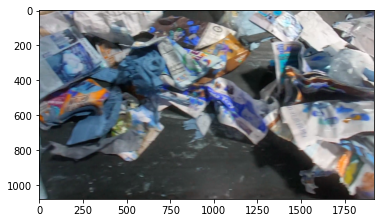

NIQE of OOF Deblurred Image: [[5.56246401]]


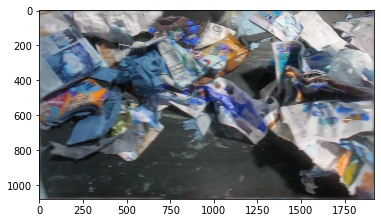

NIQE of Motion Deblurred Image: [[3.03168704]]


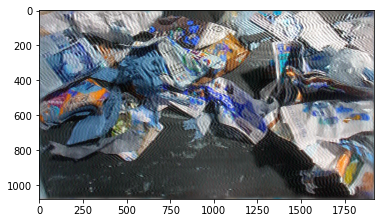

NIQE of GAN Deblurred Image: [[6.18750718]]


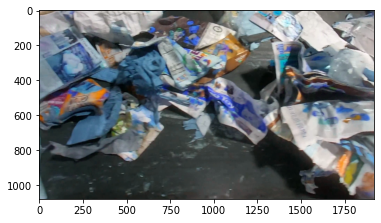

NIQE of GFN Deblurred Image: [[9.48084652]]


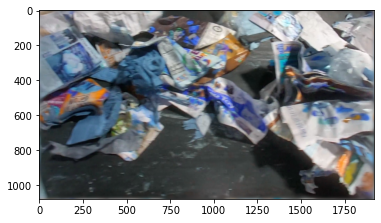

In [8]:
# compare frame 10 as well
og_path = '/projectnb/cs585/reardonc/frames/frame10.jpg'
gan_path = '/projectnb/cs585/goutermoutn/imagedeblur/gan_frames/g_frame10.jpg'
oof_path = '/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/oof_frame2.jpg'
motion_path = '/projectnb/cs585/reardonc/wiener_deconv_frames/w_frame2.jpg'
gfn_path = '/projectnb/cs585/reardonc/gfn_frames/frame10.jpg'

img1 = cv2.imread(og_path)
img2 = cv2.imread(oof_path)
img3 = cv2.imread(motion_path)
img4 = cv2.imread(gan_path)
img5 = cv2.imread(gfn_path)

niqe_result1 = calculate_niqe(img1, 0, input_order='HWC', convert_to='gray')
niqe_result2 = calculate_niqe(img2, 0, input_order='HWC', convert_to='gray')
niqe_result3 = calculate_niqe(img3, 0, input_order='HWC', convert_to='gray')
niqe_result4 = calculate_niqe(img4, 0, input_order='HWC', convert_to='gray')
niqe_result5 = calculate_niqe(img5, 0, input_order='HWC', convert_to='gray')

print("NIQE of Original Image: "+str(niqe_result1))
plt.imshow(img1)
plt.show()
print("NIQE of OOF Deblurred Image: "+str(niqe_result2))
plt.imshow(img2)
plt.show()
print("NIQE of Motion Deblurred Image: "+str(niqe_result3))
plt.imshow(img3)
plt.show()
print("NIQE of GAN Deblurred Image: "+str(niqe_result4))
plt.imshow(img4)
plt.show()
print("NIQE of GFN Deblurred Image: "+str(niqe_result5))
plt.imshow(img5)
plt.show()